CS412 PROJECT - NOTE PREDICTION

In [518]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz
import string
import nltk

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.neural_network import MLPRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances, pairwise_distances
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report

from gensim.models import Word2Vec


from collections import Counter

from nltk.metrics import jaccard_distance
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud


from nltk.stem import SnowballStemmer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\selin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Initialization

_using the code from preperepared notebook to get all of the conversations from the html files and storing them in a dictionary._

In [519]:
data_path = "dataset/*.html"
code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
            
        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "code" : file_code,
                        "role" : role,
                        "text" : convo[0].text
                    }
                )
                
        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [01:24<00:00,  1.50it/s]


_splitting the conversation to user and gpt texts to try different methods of more accurate prediction._

In [397]:
from collections import defaultdict

user_texts = defaultdict(list)
user_texts_list = []
gpt_texts = defaultdict(list)
gpt_texts_list = []

for i in code2convos:
    user_text_set = [] 
    gpt_text_set = [] 
    for j in code2convos[i]:
        if j['role'] == "user":
            user_texts[i].append(j["text"])
            user_text_set.append(j["text"])
        else:
            gpt_texts[i].append(j["text"])
            gpt_text_set.append(j["text"])

    user_texts_list.append({'code': i, 'user_texts': ' '.join(user_text_set)})
    gpt_texts_list.append({'code': i, 'gpt_texts': ' '.join(gpt_text_set)})

_concatanate every user text which will be used later on in prompt matching._

In [398]:
concat_user_texts = []
for i in user_texts_list:
    concat_user_texts.append(i["user_texts"])

_using the html tag pre to get all of the code blocks and only them for alternative methods._

In [399]:
result = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:

        fid = os.path.basename(path).split(".")[0]
        html_page = fh.read()
        soup = BeautifulSoup(html_page, "html.parser")
        codes = soup.find_all("pre")
        convo_codes = []
        for code in codes:
            convo_codes.append({
                "code" : file_code,
                "text" : code.text}  
            )
        result[file_code] = convo_codes
        
code_dict = dict()
for indcode in result:
    for line in result[indcode]:
        code = line['code']
        text = line['text']
        if code in code_dict:
            code_dict[code] += text
        else:
            code_dict[code] = text
    
only_codes = [{'code': code, 'codeblock': text} for code, text in code_dict.items()]


  0%|          | 0/127 [00:00<?, ?it/s]

100%|██████████| 127/127 [00:36<00:00,  3.50it/s]


_convert the scores csv into a dataframe._

In [400]:
scores = pd.read_csv('scores.csv', index_col=0)
print(scores.head())

                                   code  grade
0  6a2003ad-a05a-41c9-9d48-e98491a90499   90.0
1  04f91058-d0f8-4324-83b2-19c671f433dc   97.0
2  81fdeb2a-e7e5-4a05-8058-d31ea579b0d9   94.0
3  6a903495-c5be-4263-b4dd-75e2bbc30434   97.0
4  6d5742c1-77c4-429c-8f6e-ef1262ca5557   93.0


after this initial loading and preparing data, we have 4 dicts in total. We also have the scores.csv as a df named scores.
- code2convos for all the interaction within html,
- user_texts for only the users questions, and its corresponding list,
- gpt_texts for only chat's answers, and its corresponding list,
- only_codes for just the python blocks.

## Prompt Matching & Feature Engineering

### Prompt Matching

In [401]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [402]:
#using TFIDF vectorizer
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(concat_user_texts + questions)
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())

In [403]:
code2prompts_tf_idf = dict()
for code, user_prompts in user_texts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

In [404]:
#using cosine similarity
code2cosine = dict()

for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))
    
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()

question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores.head()

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.250278,0.338523,0.601349,0.357960,0.421308,0.517803,0.313625,0.344443,0.343624
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.287546,0.782936,0.821161,0.889719,0.624433,0.988523,0.898015,0.592911,0.562672
2,041f950b-c013-409a-a642-cffff60b9d4b,0.356021,0.429558,0.745656,0.448915,0.620587,0.564899,0.668887,0.662905,0.490212
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.200041,0.164364,0.283580,0.338041,0.278910,0.287890,0.235438,0.358752,0.372118
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.384756,0.545074,0.824157,0.641806,0.733244,0.883542,0.655068,0.960197,0.543510


In [405]:
#using euclidean distance
code2euclidean = dict()

for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    euclidean_distances_matrix = euclidean_distances(questions_TF_IDF, user_prompts_tf_idf)
    code2euclidean[code] = pd.DataFrame(euclidean_distances_matrix)

code2questionmapping_euclidean = dict()
for code, euclidean_distances_matrix in code2euclidean.items():
    code2questionmapping_euclidean[code] = 1 / (1 + euclidean_distances_matrix.max(axis=1).values)

question_mapping_scores_euclidean = pd.DataFrame(code2questionmapping_euclidean).T
question_mapping_scores_euclidean.reset_index(inplace=True)
question_mapping_scores_euclidean.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores_euclidean.rename(columns={"index": "code"}, inplace=True)

question_mapping_scores_euclidean.head()

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.420857,0.416835,0.421891,0.419689,0.418362,0.418482,0.420842,0.419522,0.419110
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.421442,0.421091,0.431888,0.427620,0.430325,0.425457,0.426038,0.426516,0.423185
2,041f950b-c013-409a-a642-cffff60b9d4b,0.414214,0.414214,0.414214,0.414214,0.414214,0.414214,0.414214,0.414214,0.414214
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.414214,0.414214,0.415845,0.414214,0.414214,0.414214,0.414214,0.414214,0.414214
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.414214,0.414214,0.414214,0.414214,0.414214,0.414214,0.414214,0.414214,0.414214


In [406]:
#using manhattan distance
code2manhattan = dict()

for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    manhattan_distances_matrix = manhattan_distances(questions_TF_IDF, user_prompts_tf_idf)
    code2manhattan[code] = pd.DataFrame(manhattan_distances_matrix)

code2questionmapping_manhattan = dict()
for code, manhattan_distances_matrix in code2manhattan.items():
    normalized_distances = 1 / (1 + manhattan_distances_matrix.sum(axis=1).values)
    code2questionmapping_manhattan[code] = normalized_distances

question_mapping_scores_manhattan = pd.DataFrame(code2questionmapping_manhattan).T
question_mapping_scores_manhattan.reset_index(inplace=True)
question_mapping_scores_manhattan.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores_manhattan.rename(columns={"index": "code"}, inplace=True)

question_mapping_scores_manhattan.head()

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.006833,0.008606,0.006974,0.007773,0.006928,0.007224,0.007630,0.007041,0.008720
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.006162,0.008655,0.006683,0.007249,0.006032,0.007350,0.007921,0.006951,0.008752
2,041f950b-c013-409a-a642-cffff60b9d4b,0.012111,0.016145,0.012463,0.013888,0.012018,0.013067,0.014887,0.013556,0.016760
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.005752,0.007869,0.005661,0.006691,0.005387,0.006142,0.006766,0.006060,0.008232
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.001282,0.001717,0.001283,0.001473,0.001215,0.001388,0.001529,0.001359,0.001798


During our trials, we have found that prompt matching was best fitted via using cosine similarity, so we decided to continue with that.

### Data Preprocessing

In [407]:
df_usertexts = pd.DataFrame(user_texts_list)
df_gpttexts = pd.DataFrame(gpt_texts_list)
df_codes = pd.DataFrame.from_dict(only_codes)


In [408]:
df_usertexts.tail()

,code,user_texts
122,f24219d6-07f0-4baf-80ac-18475dc5b66f,I have a machine learning homework. Described ...
123,f2f18684-4a16-4c05-a2d1-c0f96d1de869,How to handle missing values in a dataset in P...
124,f852596d-fdca-45aa-9050-d4f76ce6a53c,python for: data will be read from a file name...
125,f8ec3336-fd48-4654-ad98-62ccfb96d096,Import necessary libraries for machine learnin...
126,fb8de815-224c-4d06-9fd4-7156d1a9920d,hi i have a homework like this: CS412 - Machin...


In [409]:
df_codes.tail()

,code,codeblock
115,f24219d6-07f0-4baf-80ac-18475dc5b66f,pythonCopy codefrom sklearn.model_selection im...
116,f2f18684-4a16-4c05-a2d1-c0f96d1de869,pythonCopy codeimport pandas as pd\n\n# Assumi...
117,f852596d-fdca-45aa-9050-d4f76ce6a53c,bashCopy codepip install pandas scikit-learn\n...
118,f8ec3336-fd48-4654-ad98-62ccfb96d096,pythonCopy codeimport numpy as np\npythonCopy ...
119,fb8de815-224c-4d06-9fd4-7156d1a9920d,pythonCopy code# Import necessary libraries\ni...


In [410]:
df_gpttexts.tail()

,code,gpt_texts
122,f24219d6-07f0-4baf-80ac-18475dc5b66f,To build a decision tree classifier using scik...
123,f2f18684-4a16-4c05-a2d1-c0f96d1de869,Handling missing values is a crucial step in t...
124,f852596d-fdca-45aa-9050-d4f76ce6a53c,Certainly! Below is a Python script that addre...
125,f8ec3336-fd48-4654-ad98-62ccfb96d096,To get started with machine learning and data ...
126,fb8de815-224c-4d06-9fd4-7156d1a9920d,"Certainly! To achieve this task, you'll need t..."


In [411]:
#creating one dataframe for all the data we acquired.
merged_df = pd.merge(scores, df_gpttexts, on='code', how='outer')
merged_df = pd.merge(merged_df, df_codes, on='code', how='outer')
df = pd.merge(merged_df, df_usertexts, on='code', how='outer')


In [412]:
df.tail()

,code,grade,gpt_texts,codeblock,user_texts
141,5e481e20-f714-4f11-b941-0ef2fd5976d3,31.0,"Sure, let's go step by step:4.1.1 Correlations...",pythonCopy codeimport seaborn as sns\nimport m...,"I have this as data:\n\nShape: (3430, 11) \n\n..."
142,b24c3a33-2952-4ae4-9f2d-643d8fdbc600,78.0,Certainly! You can proceed with the following ...,pythonCopy code# Check for missing values\npri...,i have to perform this task:\nGoal\nIntroducti...
143,8be8e839-6dd0-44e0-b039-170b5b77cf2a,86.0,"In Pandas, you can display the variable names ...",pythonCopy codeimport pandas as pd\n\n# Create...,how to display variable names of a table in pa...
144,a014d72a-81ad-43a4-8a2c-8046b7666320,91.0,Certainly! To calculate correlations between f...,pythonCopy codeimport pandas as pd\nimport num...,Correlations of features with health (4 points...
145,a70ebc32-7ee1-456f-9fa1-bef302fb0e78,NaN,You can drop rows with missing values in speci...,pythonCopy codeimport pandas as pd\n\n# Create...,How to drop rows with missing values in only s...


In [413]:
nan_counts = df.isna().sum()
print(nan_counts)

code          0
grade         2
gpt_texts     1
codeblock     8
user_texts    1
dtype: int64


In [414]:
df = df.dropna()
nan_counts = df.isna().sum()
print(nan_counts)

code          0
grade         0
gpt_texts     0
codeblock     0
user_texts    0
dtype: int64


In [415]:
columns = ['gpt_texts', 'codeblock', 'user_texts']
for col in columns:
    df[col] = df[col].apply(lambda x: x.replace("pythonCopy code", " ").replace("\n", " "))
    df[col] = df[col].apply(lambda x: ''.join([' ' if char in string.punctuation else char for char in x]))
    df[col] = df[col].apply(lambda x: x.lower())


In [416]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

for col in columns:
    df[col] = df[col].apply(lambda x: word_tokenize(x))
    df[col] = df[col].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])
    df[col] = df[col].apply(lambda tokens: [stemmer.stem(word) for word in tokens])
    df[col] = df[col].apply(lambda tokens: ' '.join(tokens)) 

In [417]:
df.tail()

,code,grade,gpt_texts,codeblock,user_texts
140,6c37a2d7-f786-4fc2-ba7a-04c3f961a365,89.0,yes yes readi pleas go ahead provid prompt sub...,import panda pd sklearn model select import tr...,homework machin learn cours descript say yes u...
141,5e481e20-f714-4f11-b941-0ef2fd5976d3,31.0,sure let go step step 4 1 1 correl featur heal...,import seaborn sns import matplotlib pyplot pl...,data shape 3430 11 variabl speci island bill l...
142,b24c3a33-2952-4ae4-9f2d-643d8fdbc600,78.0,certain proceed follow step check miss valu en...,check miss valu print miss valu handl print df...,perform task goal introduct machin learn exper...
143,8be8e839-6dd0-44e0-b039-170b5b77cf2a,86.0,panda display variabl name column name datafra...,import panda pd creat sampl datafram data name...,display variabl name tabl panda python write p...
144,a014d72a-81ad-43a4-8a2c-8046b7666320,91.0,certain calcul correl featur target variabl da...,import panda pd import numpi np import seaborn...,correl featur health 4 point calcul correl fea...


### Feature Engineering

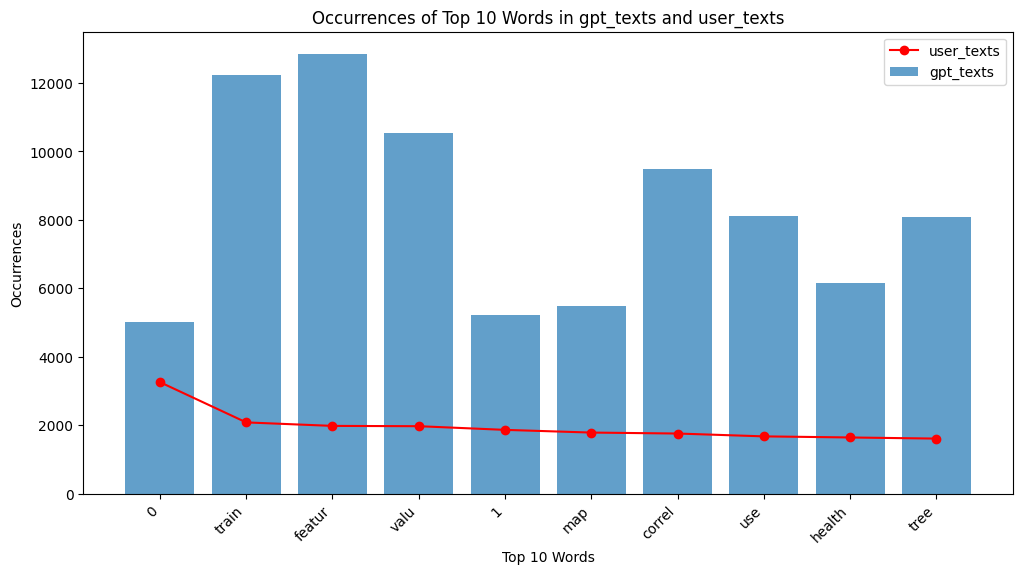

In [418]:
#finding the most common words that are in the user_texts and looking for them in gpt_texts
utext = [word.lower() for text in df['user_texts'].dropna() for word in word_tokenize(text)]
utext_counter = Counter(utext)
top_10_utext = [word for word, _ in utext_counter.most_common(10)]

gpt_text_series = df['gpt_texts'].dropna()
gpt_text_tokens = [word.lower() for text in gpt_text_series for word in word_tokenize(text)]

occurrences_count = Counter(gpt_text_tokens)
occurrences_in_gpt_texts = {word: occurrences_count[word] for word in top_10_utext}

plt.figure(figsize=(12, 6))
plt.bar(occurrences_in_gpt_texts.keys(), occurrences_in_gpt_texts.values(), label='gpt_texts', alpha=0.7)
user_texts_occurrences = [utext_counter[word] for word in top_10_utext]
plt.plot(top_10_utext, user_texts_occurrences, marker='o', color='red', label='user_texts')

plt.xlabel('Top 10 Words')
plt.ylabel('Occurrences')
plt.title('Occurrences of Top 10 Words in gpt_texts and user_texts')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()


In [419]:
#finding the most occuring words in all the texts combined
all_text_series = df['gpt_texts'] + ' ' + df['codeblock'] + ' ' + df['user_texts']
all_words = [word.lower() for text in all_text_series.dropna() for word in word_tokenize(text)]
word_counts = Counter(all_words)

plt.figure(figsize=(12, 6))
plt.bar(*zip(*word_counts.most_common(20)))  # Change 20 to the number of words you want to display
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Words')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

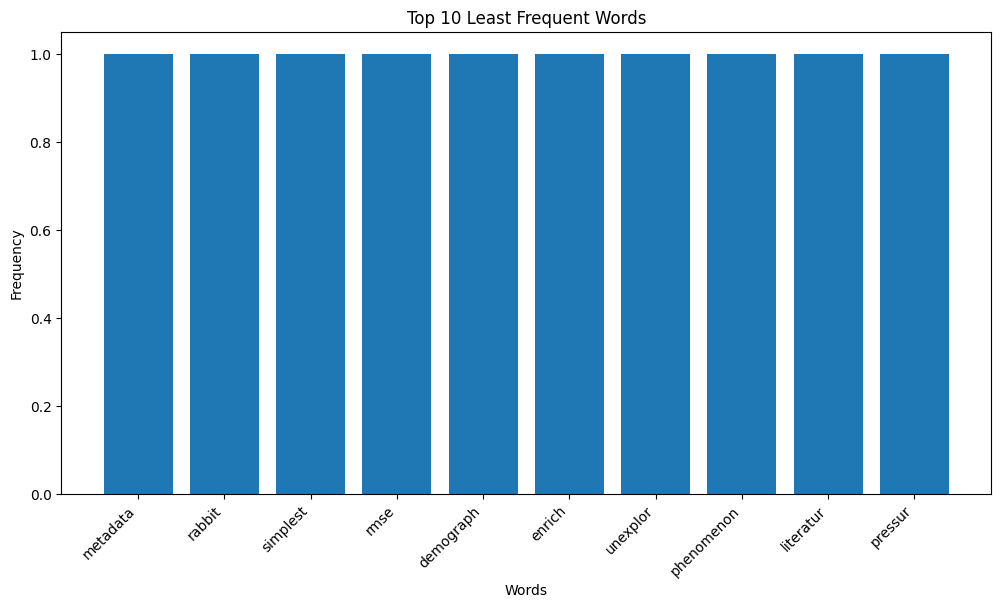

In [421]:
least_used_words = word_counts.most_common()[:-11:-1] 

plt.figure(figsize=(12, 6))
plt.bar(*zip(*least_used_words))
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Least Frequent Words')
plt.xticks(rotation=45, ha='right')
plt.show()

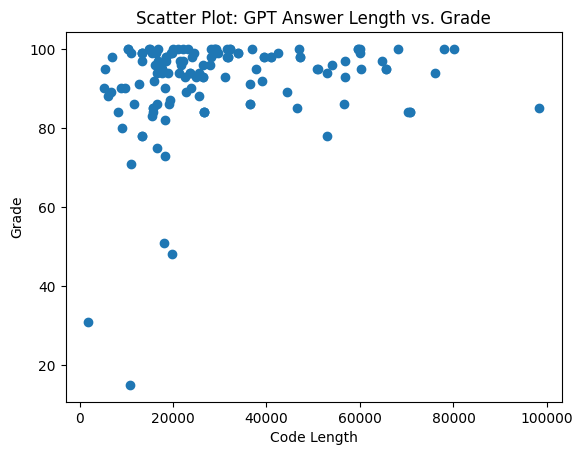

In [422]:
gpttext_lengths = df['gpt_texts'].dropna().apply(len)
plt.scatter(gpttext_lengths, df['grade'])
plt.xlabel('Code Length')
plt.ylabel('Grade')
plt.title('Scatter Plot: GPT Answer Length vs. Grade')
plt.show()

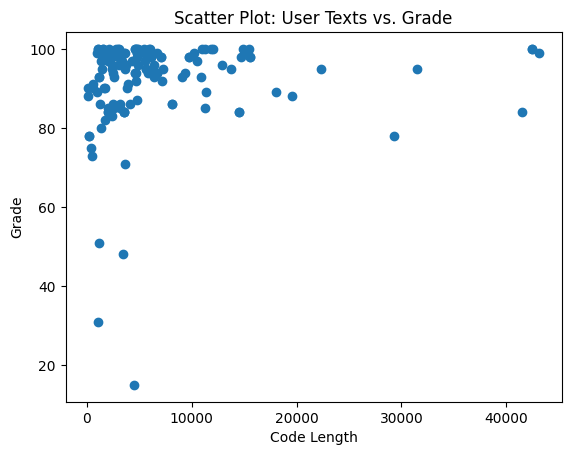

In [423]:
utext_lengths = df['user_texts'].dropna().apply(len)
plt.scatter(utext_lengths, df['grade'])
plt.xlabel('Code Length')
plt.ylabel('Grade')
plt.title('Scatter Plot: User Text Length vs. Grade')
plt.show()

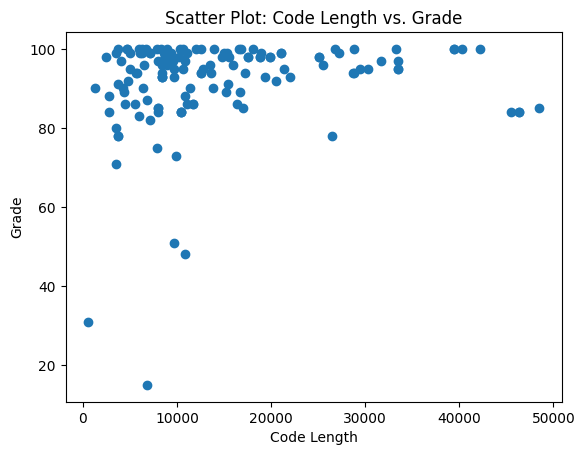

In [424]:
code_lengths = df['codeblock'].dropna().apply(len)
plt.scatter(code_lengths, df['grade'])
plt.xlabel('Code Length')
plt.ylabel('Grade')
plt.title('Scatter Plot: Code by GPT Length vs. Grade')
plt.show()

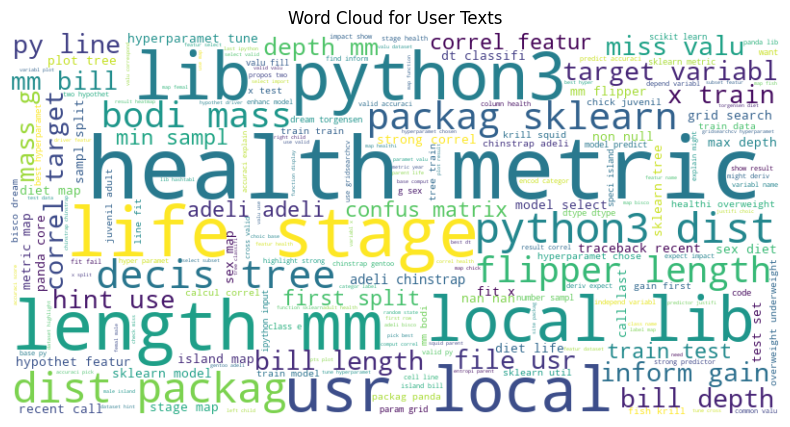

In [425]:
user_texts = ' '.join(df['user_texts'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(user_texts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for User Texts')
plt.show()

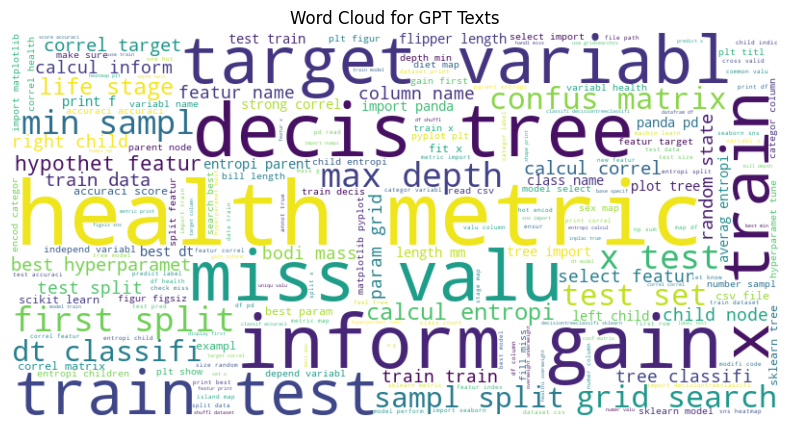

In [426]:
gpt_texts = ' '.join(df['gpt_texts'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(gpt_texts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for GPT Texts')
plt.show()

In [427]:
most_freq = []
for i in (word_counts.most_common(5)):
    most_freq.append(i[0])
most_freq

['train', 'featur', 'df', 'valu', 'correl']

In [429]:
#creating the final dataframe with all the chosen features
featuredDict = defaultdict(lambda: defaultdict(int))
k = 0
for index, row in df.iterrows():
    featuredDict[k]['grade'] = row['grade']
    featuredDict[k]['code'] = row['code']
    i = 0
    for word in most_freq:
        i += 1
        featuredDict[k][f'Word {i}'] = (row['gpt_texts'].count(word) + row['user_texts'].count(word) + row['codeblock'].count(word))
    featuredDict[k]['gptTextLength'] = len(row['gpt_texts'])
    featuredDict[k]['importCount'] = (row['codeblock']).count('import') #no of imports within the code
    k += 1
    
    
featuredDf = pd.DataFrame.from_dict(featuredDict, orient='index')
question_mapping_scores.reset_index(inplace=True)
featuredDf.rename(columns={"index" : "code"}, inplace=True)

featuredDf.head()

,grade,code,Word 1,Word 2,Word 3,Word 4,Word 5,gptTextLength,importCount
0,97.0,04f91058-d0f8-4324-83b2-19c671f433dc,240,162,109,137,59,22144,49
1,94.0,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,96,83,133,131,78,21277,30
2,97.0,6a903495-c5be-4263-b4dd-75e2bbc30434,94,13,89,114,65,21493,29
3,93.0,6d5742c1-77c4-429c-8f6e-ef1262ca5557,347,150,305,164,223,56707,61
4,98.0,dd898b12-b04b-404e-9b59-f846a162c177,255,414,230,164,165,47247,111


In [430]:
df = pd.merge(featuredDf, question_mapping_scores, on="code", how="left")
df.tail()

,grade,code,Word 1,Word 2,Word 3,Word 4,Word 5,gptTextLength,importCount,index,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
131,89.0,6c37a2d7-f786-4fc2-ba7a-04c3f961a365,481,74,0,115,45,22887,30,59,0.308732,0.448967,0.899293,1.000000,0.942582,1.000000,1.000000,0.895879,0.885167
132,31.0,5e481e20-f714-4f11-b941-0ef2fd5976d3,0,24,16,2,28,1859,3,49,0.062326,0.065084,0.107027,0.093485,0.328341,0.068677,0.094803,0.094972,0.075976
133,78.0,b24c3a33-2952-4ae4-9f2d-643d8fdbc600,463,257,163,316,108,52858,74,91,0.255449,0.307265,0.538484,1.000000,0.912285,0.791372,0.944409,0.845100,0.645047
134,86.0,8be8e839-6dd0-44e0-b039-170b5b77cf2a,82,70,108,64,75,19170,26,77,0.261670,0.313934,0.544284,0.281229,0.683389,0.759705,0.893359,0.845100,0.485854
135,91.0,a014d72a-81ad-43a4-8a2c-8046b7666320,168,180,4,100,156,36542,52,82,0.301052,0.287146,0.420857,0.213666,0.733244,0.941852,0.898015,0.507074,0.395076


## Prediction

#### prediction with the df trained in the feature engineering

Train/Test Split

In [497]:
X = df[df.columns[2:]]
y = df['grade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

CLASSIFIER

In [502]:
#Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

dt_classifier.fit(X_train, y_train)
y_pred_dt = dt_classifier.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)

print(f"Decision Tree Classifier Accuracy: {accuracy_dt:.2f}")

Decision Tree Classifier Accuracy: 0.32


In [498]:
#Gaussian Naive Bayes
gnb = GaussianNB()

gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)
accuracy_gnb = accuracy_score(y_test, y_pred_gnb)

print(f"Gaussian Naive Bayes Accuracy: {accuracy_gnb:.2f}")

Gaussian Naive Bayes Accuracy: 0.21


In [509]:
#Random Forest Classifier
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

Random Forest Accuracy: 0.39


Since with taking into account different parameters, the accuracy also changed, we wondered how it would perform in an exhaustive search.

In [ ]:
for i in range(2, 18):
    for j in range(i+1, 18):
        X = df[df.columns[i:j]]
        y = df['grade']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        #randomforest
        random_forest = RandomForestClassifier(random_state=42)
        random_forest.fit(X_train, y_train)
        y_pred_rf = random_forest.predict(X_test)
        accuracy_rf = accuracy_score(y_test, y_pred_rf)

        print(f"Random Forest Accuracy: {accuracy_rf:.2f}")
        print(f"{i}, {j}")

we found here that if we only take the first question the accuracy would be the highest, however that wouldn't be an ethical solution to a machine learning problem, so we proceeded with the 0.43.

In [462]:
#Support Vector Machine
svm_classifier = SVC(random_state=42)
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print(f"SVM Accuracy: {accuracy_svm:.2f}")

SVM Accuracy: 0.11


In [440]:
#K-Nearest Neighbors
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
y_pred_knn = knn_classifier.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred_knn)

print(f"KNN Accuracy: {accuracy_knn:.2f}")

KNN Accuracy: 0.11


In [513]:
#Gradient Boosting Classifier
gradient_boosting_classifier = GradientBoostingClassifier(random_state=42)

gradient_boosting_classifier.fit(X_train, y_train)
y_train_pred_gb = gradient_boosting_classifier.predict(X_train)
y_test_pred_gb = gradient_boosting_classifier.predict(X_test)

accuracy_train_gb = accuracy_score(y_train, y_train_pred_gb)
accuracy_test_gb = accuracy_score(y_test, y_test_pred_gb)

print("Gradient Boosting Classifier:")
print("Accuracy Train:", accuracy_train_gb)
print("Accuracy Test:", accuracy_test_gb)

Gradient Boosting Classifier:
Accuracy Train: 1.0
Accuracy Test: 0.32142857142857145


REGRESSION

In [507]:
#Gradient Boosting Regressor
gradient_boosting_regressor = GradientBoostingRegressor(random_state=42)

gradient_boosting_regressor.fit(X_train, y_train)
y_train_pred_gb = gradient_boosting_regressor.predict(X_train)
y_test_pred_gb = gradient_boosting_regressor.predict(X_test)
r2_train_gb = r2_score(y_train, y_train_pred_gb)
r2_test_gb = r2_score(y_test, y_test_pred_gb)

print("Gradient Boosting Regressor:")
print("R2 Train:", r2_train_gb)
print("R2 Test:", r2_test_gb)

Gradient Boosting Regressor:
R2 Train: 0.9937693347822889
R2 Test: 0.309683568460161


In [504]:
#Random Forest Reggressor
random_forest_regressor = RandomForestRegressor(random_state=42)

random_forest_regressor.fit(X_train, y_train)
y_train_pred_rf = random_forest_regressor.predict(X_train)
y_test_pred_rf = random_forest_regressor.predict(X_test)
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)

print("Random Forest Regressor:")
print("MSE Train:", mse_train_rf)
print("MSE Test:", mse_test_rf)
print("R2 Train:", r2_train_rf)
print("R2 Test:", r2_test_rf)

Random Forest Regressor:
MSE Train: 25.872862037037034
MSE Test: 122.18346071428574
R2 Train: 0.8054727201235565
R2 Test: 0.30337265322744844


In [452]:
#Decision Tree Regressor
regressor = DecisionTreeRegressor(random_state=0,criterion='squared_error', max_depth=10)
regressor.fit(X_train, y_train)
extracted_MSEs = regressor.tree_.impurity   
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))
    
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))

Node 0 has MSE 133.00377229080914
Node 1 has MSE 77.98335706657235
Node 2 has MSE 0.0
Node 3 has MSE 59.18312925169994
Node 4 has MSE 217.53719008264397
Node 5 has MSE 53.5
Node 6 has MSE 28.6875
Node 7 has MSE 0.0
Node 8 has MSE 0.22222222222262644
Node 9 has MSE 0.0
Node 10 has MSE 0.0
Node 11 has MSE 0.1875
Node 12 has MSE 0.0
Node 13 has MSE 0.0
Node 14 has MSE 118.22222222222263
Node 15 has MSE 0.0
Node 16 has MSE 1.0
Node 17 has MSE 0.0
Node 18 has MSE 0.0
Node 19 has MSE 33.449071978271604
Node 20 has MSE 31.290000000000873
Node 21 has MSE 29.54545454545405
Node 22 has MSE 35.0645161290322
Node 23 has MSE 21.421597633134297
Node 24 has MSE 13.900059488398256
Node 25 has MSE 17.33333333333394
Node 26 has MSE 2.25
Node 27 has MSE 2.1875
Node 28 has MSE 8.388571428571595
Node 29 has MSE 6.632222222222481
Node 30 has MSE 5.43999999999869
Node 31 has MSE 32.19834710743817
Node 32 has MSE 0.25
Node 33 has MSE 0.0
Node 34 has MSE 0.0
Node 35 has MSE 20.913580246914535
Node 36 has MSE 9

#### experimental prediction without using the dataframe

Before carefully reading the project document, we wondered whether it be possible to train these models while using only the texts that we have simplified, tokenized etc. Although we didn't follow through, we still tried it as an experimentation. As probably expected, the values weren't too good.

In [481]:
gptwithscores = pd.merge(df_gpttexts, scores, on="code", how="left")
gptwithscores.dropna(inplace=True)

textwithscores = pd.merge(df_usertexts, scores, on="code", how="left")
textwithscores.dropna(inplace=True)

In [486]:
textwithscores.head()

,code,user_texts,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,Load a CSV file into a Pandas in Python. The f...,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,I have a dataset that contains the following c...,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,I have a csv file data with Columns:\n\nspecie...,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,How can I display variable names in a pandas d...,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,I am doing a machine leraning homework using g...,100.0


In [485]:
gptwithscores['gpt_texts'] = gptwithscores['gpt_texts'].apply(lambda x: x.replace("pythonCopy code", " ").replace("\n", " "))
gptwithscores['gpt_texts'] = gptwithscores['gpt_texts'].apply(lambda x: ''.join([' ' if char in string.punctuation else char for char in x]))
gptwithscores['gpt_texts'] = gptwithscores['gpt_texts'].apply(lambda x: x.lower())

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

gptwithscores['gpt_texts'] = gptwithscores['gpt_texts'].apply(lambda x: word_tokenize(x))
gptwithscores['gpt_texts'] = gptwithscores['gpt_texts'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])
gptwithscores['gpt_texts'] = gptwithscores['gpt_texts'].apply(lambda tokens: [stemmer.stem(word) for word in tokens])
gptwithscores['gpt_texts'] = gptwithscores['gpt_texts'].apply(lambda tokens: ' '.join(tokens)) 

In [487]:
textwithscores['user_texts'] = textwithscores['user_texts'].apply(lambda x: x.replace("pythonCopy code", " ").replace("\n", " "))
textwithscores['user_texts'] = textwithscores['user_texts'].apply(lambda x: ''.join([' ' if char in string.punctuation else char for char in x]))
textwithscores['user_texts'] = textwithscores['user_texts'].apply(lambda x: x.lower())

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

textwithscores['user_texts'] = textwithscores['user_texts'].apply(lambda x: word_tokenize(x))
textwithscores['user_texts'] = textwithscores['user_texts'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])
textwithscores['user_texts'] = textwithscores['user_texts'].apply(lambda tokens: [stemmer.stem(word) for word in tokens])
textwithscores['user_texts'] = textwithscores['user_texts'].apply(lambda tokens: ' '.join(tokens)) 

In [491]:
#Random Forest Regressor with TFIDF, Prediction based on the answers Chat_GPT generated
X_gpt = gptwithscores['gpt_texts']
y_gpt = gptwithscores['grade']

tfidf_vectorizer = TfidfVectorizer(max_features=5000)  
X_tfidf = tfidf_vectorizer.fit_transform(X_gpt)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y_gpt, test_size=0.2, random_state=42)
random_forest_regressor = RandomForestRegressor(random_state=42)
random_forest_regressor.fit(X_train_tfidf, y_train)
y_pred_rf = random_forest_regressor.predict(X_test_tfidf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print the metrics
print(f"Random Forest Mean Squared Error: {mse_rf:.2f}")
print(f"Random Forest R-squared: {r2_rf:.2f}")


Random Forest Mean Squared Error: 42.38
Random Forest R-squared: -0.75


In [489]:
#Random Forest Regressor with TFIDF, Prediction based on the prompts users wrote.

X_user = textwithscores['user_texts']
y_user = textwithscores['grade']

tfidf_vectorizer = TfidfVectorizer(max_features=5000)  
X_tfidf = tfidf_vectorizer.fit_transform(X_user)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y_user, test_size=0.2, random_state=42)
random_forest_regressor = RandomForestRegressor(random_state=42)
random_forest_regressor.fit(X_train_tfidf, y_train)
y_pred_rf = random_forest_regressor.predict(X_test_tfidf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print the metrics
print(f"Random Forest Mean Squared Error: {mse_rf:.2f}")
print(f"Random Forest R-squared: {r2_rf:.2f}")


Random Forest Mean Squared Error: 41.12
Random Forest R-squared: -0.69
